In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from itertools import product
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
%load_ext tensorboard
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")

PATH_DATA = "../datasets/SARS2/"

In [90]:
def get_features_morgan(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = {}
    fps = {}
    mol_names = set()
    error_mols = 0
    for mol in structures_shared:
        if mol is None:
            error_mols += 1
            continue
        if mol.GetProp("Name") in mol_names:
            continue
        name = int(mol.GetProp("Name"))
        mol_names.add(name)
        key = Chem.inchi.MolToInchiKey(mol)
        if (name, key) not in features:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
            fps[(name, key)] = fp
            arr = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp,arr)
            features[(name, key)] = arr
    print(f"Found problems in {error_mols} molecules")
    return fps, features, mol_names

In [91]:
fps_morgan, features_morgan, names_morgan = get_features_morgan(os.path.join(PATH_DATA, "SIM_Broad_MProResults_ligprep.sd"))

RDKit ERROR: [10:18:13] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 9 12
RDKit ERROR: 
RDKit ERROR: [10:25:39] Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [10:25:39] ERROR: Could not sanitize molecule ending on line 7247
RDKit ERROR: [10:25:39] ERROR: Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [10:25:39] Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [10:25:39] ERROR: Could not sanitize molecule ending on line 7448
RDKit ERROR: [10:25:39] ERROR: Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [10:25:39] Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [10:25:39] ERROR: Could not sanitize molecule ending on line 7649
RDKit ERROR: [10:25:39] ERROR: Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [10:25:39] Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit

Found problems in 24 molecules


RDKit ERROR: [10:25:39] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [10:25:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 8 12
RDKit ERROR: 
RDKit ERROR: [10:25:39] ERROR: Could not sanitize molecule ending on line 33106
RDKit ERROR: [10:25:39] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 8 12
RDKit ERROR: 
RDKit ERROR: [10:25:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 9 12
RDKit ERROR: 
RDKit ERROR: [10:25:39] ERROR: Could not sanitize molecule ending on line 33166


In [122]:
threshold_activity = 20 # uM
data_orig_broad = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-broad.csv"), decimal=",")
data_orig_dompe = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-dompe.csv"), decimal=",")
data_orig_broad = data_orig_broad.rename(columns={"NAME": "Name",
                                                  "3CL-Pro IC50-15min (µM) (triplicates)": "IC50 µM 15 min",
                                                  "3CLpro\n IC50 slope (µM) (triplicates)": "IC50 µM slope"                                                 })
data_orig_dompe = data_orig_dompe.rename(columns={"IC50 µM\n 15 min\n (red manually confirmed)": "IC50 µM 15 min",
                                                  "IC50 µM\n slope\n (red manually confirmed)": "IC50 µM slope"})
data_full = pd.concat([data_orig_broad, data_orig_dompe])

correspondance_broad = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_broad.csv"), decimal=",")
correspondance_broad = correspondance_broad.rename(columns={"Molecule_id": "Molecule_ID"})
correspondance_dompe = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_dompe.csv"), decimal=",")
correspondance = pd.concat([correspondance_broad, correspondance_dompe])
correspondance = correspondance.rename(columns={"Fraunofer Compound Id": "Compound Id"})
data_full = data_full.merge(correspondance, how="inner", on="Compound Id")

In [123]:
active = (data_full["IC50 µM 15 min"] < threshold_activity).values.astype(int)
data_full["Is_active"] = active
print(data_full.shape)

(191, 32)


In [124]:
dup = data_full.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
all_dup = data_full.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep=False)

In [125]:
data_full[all_dup]

,Compound Id,Name,DTT sensitivity (if > 30 % loss of activity at 20 µM),Inhibition [%] Primary Screen (single point; 20 µM),"HC\nInhibition [%] (triplicate, 20 µM)","HC\n AV Inhibition [%] (triplicate, 20 µM)\nslope",AV inhibition +DTT 15min \nduplicates,IC50 µM 15 min,IC50 µM slope,%inhibition_d03-KU_LW,...,AV Inhibiton\n 15min,%Inhibition\n_slope PS,%Inhibition\n_15min PS,VeroE6% \nConfluence_d03,VeroE6 % \nInhibition_d03,Chemically reactive?,Molecule_ID,Standardized_Molecule_InChIKey,Standardized_Molecule_Smiles,Is_active
8,SPE_K81330143,Tideglusib,sensitiv,90.94,99.30,99.28,-4.89,0.15,0.14,-3.46,...,NaN,NaN,NaN,NaN,NaN,NaN,3878,PMJIHLSCWIDGMD-UHFFFAOYSA-N,O=C1SN(C(=O)N1Cc2ccccc2)c3cccc4ccccc34,1
9,SPE_K34149328,bonaphthone,sensitiv,95.47,99.37,100.31,37.44,0.16,0.38,-1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,4448,MXWZRRPNVLCHMY-UHFFFAOYSA-N,Brc1ccc2C(=O)C(=O)C=Cc2c1,1
30,SPE_K86972824,OLTIPRAZ,sensitiv,93.83,97.56,101.75,1.56,0.62,1.44,6.11,...,NaN,NaN,NaN,NaN,NaN,NaN,8437,CKNAQFVBEHDJQV-UHFFFAOYSA-N,CC1=C(SSC1=S)c2cnccn2,1
33,SPE_K55591206,(-)-Epigallocatechin Gallate,sensitiv,95.26,98.89,97.04,-22.36,0.72,1.29,-1.41,...,NaN,NaN,NaN,NaN,NaN,NaN,522,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@H...,1
38,SPE_K68408467,PROFLAVINE HEMISULFATE,sensitiv,60.89,76.55,99.87,20.41,0.83,2.02,19.09,...,NaN,NaN,NaN,NaN,NaN,NaN,6835,WDVSHHCDHLJJJR-UHFFFAOYSA-N,Nc1ccc2cc3ccc(N)cc3nc2c1,1
58,SPE_M87138257,Acriflavine hydrochloride,Acriflavine hydrochloride,59.00,67.97,99.10,68.22,1.93,5.10,-26.74,...,NaN,NaN,NaN,NaN,NaN,NaN,6864,NLROCEWTIPMDKX-UHFFFAOYSA-N,C[N]1=C2C=C(N)C=CC2=Cc3ccc(N)cc13,1
74,SPE_K20313525,rosmarinic-acid,sensitiv,95.67,94.92,94.14,-17.76,3.86,4.96,8.26,...,NaN,NaN,NaN,NaN,NaN,NaN,8605,DOUMFZQKYFQNTF-WUTVXBCWSA-N,OC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)\C=C\c2ccc(...,1
80,SPE_K97874492,ACRIFLAVINIUM HYDROCHLORIDE,sensitiv,75.15,82.15,97.08,-1.10,4.98,9.76,9.74,...,NaN,NaN,NaN,NaN,NaN,NaN,6864,NLROCEWTIPMDKX-UHFFFAOYSA-N,C[N]1=C2C=C(N)C=CC2=Cc3ccc(N)cc13,1
95,SPE_A49172652,LANSOPRAZOLE,sensitiv,97.15,98.57,96.07,-12.10,7.25,10.83,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,348,MJIHNNLFOKEZEW-UHFFFAOYSA-N,Cc1c(OCC(F)(F)F)ccnc1CS(=O)c2nc3ccccc3[nH]2,1
112,SPE_K76841105,Tazarotene (Avage),Tazarotene (Avage),-880.10,-692.49,108.07,-663.39,13.50,321.75,-2.40,...,NaN,NaN,NaN,NaN,NaN,NaN,445,OGQICQVSFDPSEI-UHFFFAOYSA-N,CCOC(=O)c1ccc(nc1)C#Cc2ccc3SCCC(C)(C)c3c2,1


In [135]:
data_full = data_full[~dup]
active = active[~dup]
print(data_full.shape)

(181, 32)


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [177]:
def get_molecules_from_data(features, fps, data):
    mol_ids = data["Molecule_ID"]
    keys = data["Standardized_Molecule_InChIKey"]
    filtered_features = []
    filtered_fps = []
    mask = []
    for id_val in zip(mol_ids, keys):
        mask.append(id_val in features)
        if id_val in features:
            filtered_features.append(features[id_val])
            filtered_fps.append(fps[id_val])
        else:
            print(id_val)
            print([k for k in features if k[0] == id_val[0]])
    return np.array(filtered_features), filtered_fps, mask

In [178]:
features_full, fps_full, mask = get_molecules_from_data(features_morgan, fps_morgan, data_full)

(11947, 'HXQVQGWHFRNKMS-UHFFFAOYSA-M')
[]
(12210, 'XEBWQGVWTUSTLN-UHFFFAOYSA-M')
[]
(5185, 'BPBPYQWMFCTCNG-UHFFFAOYSA-N')
[(5185, 'BPBPYQWMFCTCNG-ZCFIWIBFSA-N'), (5185, 'BPBPYQWMFCTCNG-LURJTMIESA-N')]
(9599, 'BNQDCRGUHNALGH-UHFFFAOYSA-N')
[(9599, 'BNQDCRGUHNALGH-ZCFIWIBFSA-O'), (9599, 'BNQDCRGUHNALGH-ZCFIWIBFSA-N')]
(10107, 'IYUHJBHUQSINCX-XTZHGVARSA-O')
[]
(11027, 'OHCFGBLQZMYRTR-UHFFFAOYSA-M')
[(11027, '')]
(11142, 'GSASOFRDSIKDSN-UHFFFAOYSA-N')
[(11142, 'GSASOFRDSIKDSN-UHFFFAOYSA-L')]
(11287, 'GCHPUOHXXCNSQL-UHFFFAOYSA-N')
[(11287, 'GCHPUOHXXCNSQL-HDICACEKSA-N')]
(8432, 'XKFZYVWWXHCHIX-UHFFFAOYSA-N')
[(8432, 'XKFZYVWWXHCHIX-UHFFFAOYSA-M')]
(617, 'VMWNQDUVQKEIOC-CYBMUJFWSA-N')
[(617, 'VMWNQDUVQKEIOC-CYBMUJFWSA-O')]
(11456, 'JSASWRWALCMOQP-UHFFFAOYSA-N')
[(11456, 'JSASWRWALCMOQP-UHFFFAOYSA-O')]
(882, 'OBMJQRLIQQTJLR-USGQOSEYSA-N')
[(882, 'OBMJQRLIQQTJLR-LJSDLLOGSA-O'), (882, 'OBMJQRLIQQTJLR-USGQOSEYSA-O')]
(332, 'GYQPLLUBTBEWII-UHFFFAOYSA-N')
[(332, 'IXWFLTGIVKLPDY-IBGZPJMESA-N')]
(10

In [129]:
data_full[data_full["Molecule_ID"] == 8605]

,Compound Id,Name,DTT sensitivity (if > 30 % loss of activity at 20 µM),Inhibition [%] Primary Screen (single point; 20 µM),"HC\nInhibition [%] (triplicate, 20 µM)","HC\n AV Inhibition [%] (triplicate, 20 µM)\nslope",AV inhibition +DTT 15min \nduplicates,IC50 µM 15 min,IC50 µM slope,%inhibition_d03-KU_LW,...,AV Inhibiton\n 15min,%Inhibition\n_slope PS,%Inhibition\n_15min PS,VeroE6% \nConfluence_d03,VeroE6 % \nInhibition_d03,Chemically reactive?,Molecule_ID,Standardized_Molecule_InChIKey,Standardized_Molecule_Smiles,Is_active
74,SPE_K20313525,rosmarinic-acid,sensitiv,95.67,94.92,94.14,-17.76,3.86,4.96,8.26,...,NaN,NaN,NaN,NaN,NaN,NaN,8605,DOUMFZQKYFQNTF-WUTVXBCWSA-N,OC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)\C=C\c2ccc(...,1


In [130]:
(data_full[data_full["Molecule_ID"] == 8605]["Standardized_Molecule_InChIKey"].values[0] == 'DOUMFZQKYFQNTF-WUTVXBCWSA-N')

True

In [134]:
len(mask)

181

In [138]:
data_filtered = data_full[mask]
active = active[mask]

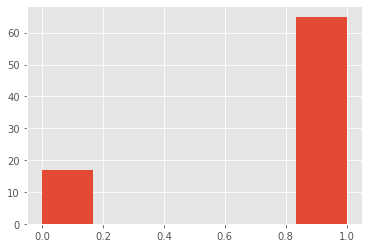

In [139]:
plt.hist(active, bins=6);

In [167]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])

In [140]:
train_data, test_data, train_labels, test_labels = train_test_split(features_full, active, test_size=0.25, random_state=42, stratify=active)

In [159]:
accuracy = []
MCCs = []
C_values = np.geomspace(0.01, 1000, num=30)
gamma_values = np.geomspace(0.001, 100, num=30)
for c_val in C_values:
    acc = []
    mcc = []
    for gamma in gamma_values:
        svm = SVC(C=c_val, kernel="rbf", gamma=gamma)
        svm.fit(train_data, train_labels)
        predictions = svm.predict(test_data)
        vals = print_metrics(predictions, test_labels)
        acc.append(vals[0])
        mcc.append(vals[1])
    accuracy.append(acc)
    MCCs.append(mcc)

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificit

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specif

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.810, Correctly classified: 0.810, MCC: nan
NER: 0.500, Sensitivity or recall: 1.000, Sp

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461
NER: 0.625, Sensitivity or recall: 1.000

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/

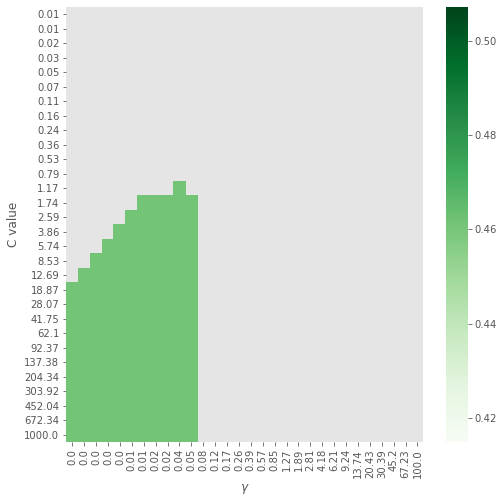

In [163]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(MCCs, annot=False, ax = ax, cmap="Greens")
ax.set_yticklabels(np.round(C_values, 2), rotation=0)
ax.set_xticklabels(np.round(gamma_values, 2), rotation=90)
ax.set_ylabel("C value")
ax.set_xlabel(r"$\gamma$")
plt.show()

NER: 0.625, Sensitivity or recall: 1.000, Specificity: 0.250, Precision: 0.850, Correctly classified: 0.857, MCC: 0.461


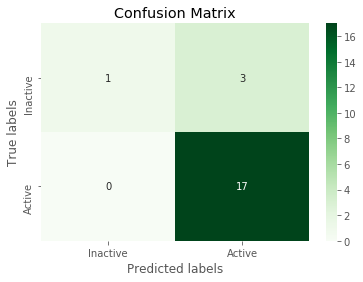

In [168]:
C= 20
gamm = 0.05
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(train_data, train_labels)
predictions = svm.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)